In [ ]:
!pip install pyspark
!pip install sparknlp

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date,date_format,year,month,split,col,sum,when,expr,regexp_replace,lower,collect_list,concat_ws
import matplotlib.pyplot as plt
from pyspark.ml.feature import StopWordsRemover
from wordcloud import WordCloud
from pyspark.sql.window import Window

In [ ]:
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml.classification import NaiveBayes
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master('local[*]').getOrCreate()

In [ ]:
df =spark.read.csv('/content/drive/MyDrive/London_reviews.csv', header=True, inferSchema=True)

In [ ]:
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- parse_count: string (nullable = true)
 |-- restaurant_name: string (nullable = true)
 |-- rating_review: string (nullable = true)
 |-- sample: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- title_review: string (nullable = true)
 |-- review_preview: string (nullable = true)
 |-- review_full: string (nullable = true)
 |-- date: string (nullable = true)
 |-- city: string (nullable = true)
 |-- url_restaurant: string (nullable = true)
 |-- author_id: string (nullable = true)



In [ ]:
df_pos = df.select("sample","review_full").filter(df["rating_review"]=="5.0").limit(100000)

In [ ]:
df_neg = df.select("sample","review_full").filter(df["rating_review"]=="1.0")

In [ ]:
df_neg.count()

35931

In [ ]:

from pyspark.ml.feature import StopWordsRemover
from wordcloud import WordCloud
import matplotlib.pyplot as plt


df_pos= df_pos.withColumn("cleaned_review", regexp_replace(df_pos["review_full"], r'[^\w\s]', ''))
df_pos = df_pos.withColumn("cleaned_review", lower(df_pos["cleaned_review"]))
df_pos= df_pos.withColumn("tokens", split(df_pos["cleaned_review"], " "))
remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")
df_pos = remover.transform(df_pos)
df_pos = df_pos.withColumn("cleaned_review", concat_ws(" ", col("review_full")))

batch_size = 1000
total_rows = df_pos.count()
start_index = 0
aggregated_text_chunks = []
try:
  while start_index < total_rows:
    # Extract a batch of data
    batch_df = df_pos.select("cleaned_review").limit(batch_size)

    # Perform aggregation on the batch
    aggregated_text_batch = batch_df.agg(concat_ws(" ", collect_list("cleaned_review"))).collect()[0][0]

    # Append the aggregated result to the list
    aggregated_text_chunks.append(aggregated_text_batch)

    # Increment the starting index for the next batch
    start_index += batch_size

# Concatenate the results of all batches
  final_aggregated_text = " ".join(aggregated_text_chunks)


except Exception as e:
  print(f"An error occurred: {e}")

In [ ]:
try:
  wordcloud = WordCloud(width=800, height=400, background_color="white").generate(final_aggregated_text)
except Exception as e:
  print(f"An error occurred: {e}")


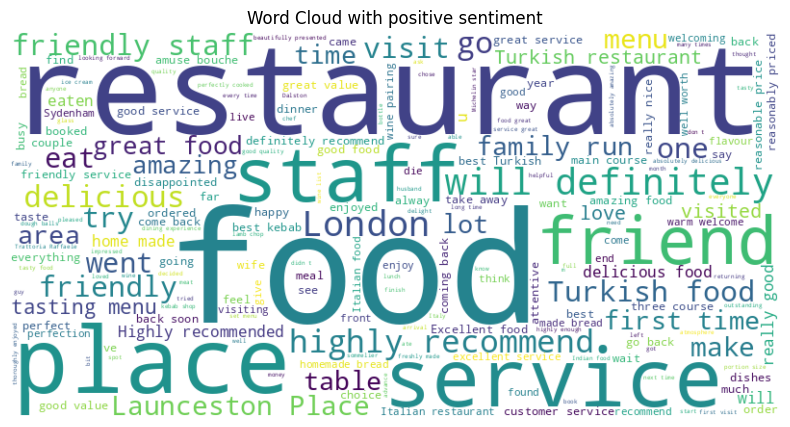

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Word Cloud with positive sentiment')
plt.show()

In [ ]:
df_neg= df_neg.withColumn("cleaned_review", regexp_replace(df_neg["review_full"], r'[^\w\s]', ''))
df_neg = df_neg.withColumn("cleaned_review", lower(df_neg["cleaned_review"]))
df_neg= df_neg.withColumn("tokens", split(df_neg["cleaned_review"], " "))
remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")
df_neg = remover.transform(df_neg)
df_neg = df_neg.withColumn("cleaned_review", concat_ws(" ", col("review_full")))

batch_size = 1000
total_rows = df_neg.count()
start_index = 0
aggregated_text_chunks = []
try:
  while start_index < total_rows:
    # Extract a batch of data
    batch_df = df_neg.select("cleaned_review").limit(batch_size)

    # Perform aggregation on the batch
    aggregated_text_batch = batch_df.agg(concat_ws(" ", collect_list("cleaned_review"))).collect()[0][0]

    # Append the aggregated result to the list
    aggregated_text_chunks.append(aggregated_text_batch)

    # Increment the starting index for the next batch
    start_index += batch_size

# Concatenate the results of all batches
  final_aggregated_text = " ".join(aggregated_text_chunks)


except Exception as e:
  print(f"An error occurred: {e}")

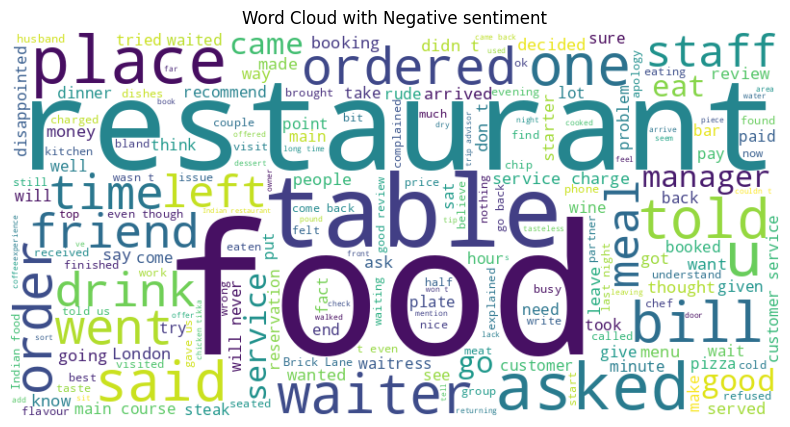

In [ ]:
try:
  wordcloud = WordCloud(width=800, height=400, background_color="white").generate(final_aggregated_text)
except Exception as e:
  print(f"An error occurred: {e}")
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Word Cloud with Negative sentiment')
plt.show()


In [ ]:
df.show(10)

+---+-----------+--------------------+-------------+--------+----------------+--------------------+--------------------+--------------------+------------------+--------------+--------------------+---------+
|_c0|parse_count|     restaurant_name|rating_review|  sample|       review_id|        title_review|      review_preview|         review_full|              date|          city|      url_restaurant|author_id|
+---+-----------+--------------------+-------------+--------+----------------+--------------------+--------------------+--------------------+------------------+--------------+--------------------+---------+
|  0|          1|Cocotte_Notting_Hill|          5.0|Positive|review_771556136|        JUST PERFECT|I was away for co...|I was away for co...|September 23, 2020|London_England|https://www.tripa...|    UID_0|
|  1|          2|Cocotte_Notting_Hill|          5.0|Positive|review_771555883|Quality food, Foo...|I recently ordere...|I recently ordere...|September 23, 2020|London_Engla

In [ ]:
cols=['review_id','city','url_restaurant','author_id']
df = df.drop(*cols)

In [ ]:
df.count()

996848

In [ ]:
columns = df.columns
exprs = [sum(col(c).isNull().cast("int")).alias(c) for c in columns]
na_value_counts = df.agg(*exprs)
na_value_counts.show()

+---+-----------+---------------+-------------+------+------------+--------------+-----------+----+
|_c0|parse_count|restaurant_name|rating_review|sample|title_review|review_preview|review_full|date|
+---+-----------+---------------+-------------+------+------------+--------------+-----------+----+
|  0|         14|             17|           17|    17|          37|           538|        574| 588|
+---+-----------+---------------+-------------+------+------------+--------------+-----------+----+



In [ ]:
df.count()

996848

In [ ]:
df = df.withColumn("columns", split(df["date"], ", "))
df = df.withColumn("month_date", df["columns"].getItem(0))
df = df.withColumn("year", df["columns"].getItem(1))
df = df.withColumn("columns1",split(df["month_date"], " "))
df = df.withColumn("month", df["columns1"].getItem(0))
df = df.withColumn("date", df["columns1"].getItem(1))
df = df.drop("columns","columns1","month_date")

In [ ]:
df.show(10)

+---+-----------+--------------------+-------------+--------+--------------------+--------------------+--------------------+----+----+---------+
|_c0|parse_count|     restaurant_name|rating_review|  sample|        title_review|      review_preview|         review_full|date|year|    month|
+---+-----------+--------------------+-------------+--------+--------------------+--------------------+--------------------+----+----+---------+
|  0|          1|Cocotte_Notting_Hill|          5.0|Positive|        JUST PERFECT|I was away for co...|I was away for co...|  23|2020|September|
|  1|          2|Cocotte_Notting_Hill|          5.0|Positive|Quality food, Foo...|I recently ordere...|I recently ordere...|  23|2020|September|
|  2|          3|Cocotte_Notting_Hill|          5.0|Positive|Came here because...|Came here because...|Came here because...|  17|2020|September|
|  3|          4|Cocotte_Notting_Hill|          5.0|Positive|       Great service|My first time in ...|My first time in ...|  12|2

In [ ]:
years = [*range(2004,2023,1)]
trash = df.filter(~df["year"].isin(years))
trash.show()
trash.count()

+-----+-----------+--------------------+-------------+--------+--------------------+--------------------+--------------------+----------+--------------------+------------+
|  _c0|parse_count|     restaurant_name|rating_review|  sample|        title_review|      review_preview|         review_full|      date|                year|       month|
+-----+-----------+--------------------+-------------+--------+--------------------+--------------------+--------------------+----------+--------------------+------------+
| 2565|       2566|          Wild_Thyme|          5.0|Positive|Our favourite pla...|"We've been here ...| the Eggs Benedic...|      been|the food came out...|      "We've|
| 7401|       7402|         The_Monsoon|          5.0|Positive|Curry experience ...|"I visited this c...|   he managed to..."|   visited|after having been...|          "I|
| 7452|       7453|         The_Monsoon|          3.0|Negative|           tasteless|"Whilst travellin...| ""3 course meal ...|travelling|my 

2372

In [ ]:
df =df.filter(df['year'].isin(years))
senti = ["Positive","Negative"]
trash = df.filter(~df['sample'].isin(senti))
trash.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----+----+--------+
|                 _c0|         parse_count|     restaurant_name|       rating_review|              sample|        title_review|      review_preview|         review_full|date|year|   month|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----+----+--------+
|",They are extrem...| just warm. There...| walk around Camd...|            desserts| juices and hot d...| I probably would...| two tables had f...| I think that the...|  23|2019|November|
| Nice Greek resta...|","Halepi Nice Gr...| always full of p...|           good food| I ordered Greek ...|   The owner is v...|        about 39..."|Halepi  Nice Gree...|  25|2020| January|
|","If you can ple...| it was not enoug...| breaded chi

In [ ]:
df = df.filter(df['sample'].isin(senti))
df.count()

964731

In [ ]:
trash = df.filter(~df['rating_review'].isin(1.0,2.0,3.0,4.0,5.0))
Yearly_count = df.groupBy("year","sample").count().orderBy("year")
Yearly_count.show(40)

+----+--------+------+
|year|  sample| count|
+----+--------+------+
|2004|Positive|     1|
|2005|Positive|     2|
|2006|Positive|     6|
|2006|Negative|     1|
|2007|Positive|    53|
|2007|Negative|    18|
|2008|Negative|   131|
|2008|Positive|   389|
|2009|Negative|   310|
|2009|Positive|  1071|
|2010|Negative|   724|
|2010|Positive|  2295|
|2011|Negative|  2301|
|2011|Positive|  8865|
|2012|Positive| 29206|
|2012|Negative|  6572|
|2013|Positive| 50611|
|2013|Negative| 10890|
|2014|Negative| 14995|
|2014|Positive| 72837|
|2015|Negative| 19459|
|2015|Positive|104911|
|2016|Negative| 24039|
|2016|Positive|131928|
|2017|Positive|128716|
|2017|Negative| 23519|
|2018|Positive|121878|
|2018|Negative| 22462|
|2019|Positive|119383|
|2019|Negative| 21540|
|2020|Negative|  6686|
|2020|Positive| 38932|
+----+--------+------+



In [ ]:
Yearly_Count1 = Yearly_count.withColumn("sentiment_color", expr("CASE WHEN sample = 'Positive' THEN 'green' ELSE 'red' END"))
data = Yearly_Count1.select('year', 'count', 'sentiment_color').orderBy('year','sentiment_color').collect()
# Unzip the data
years, counts, colors = zip(*data)

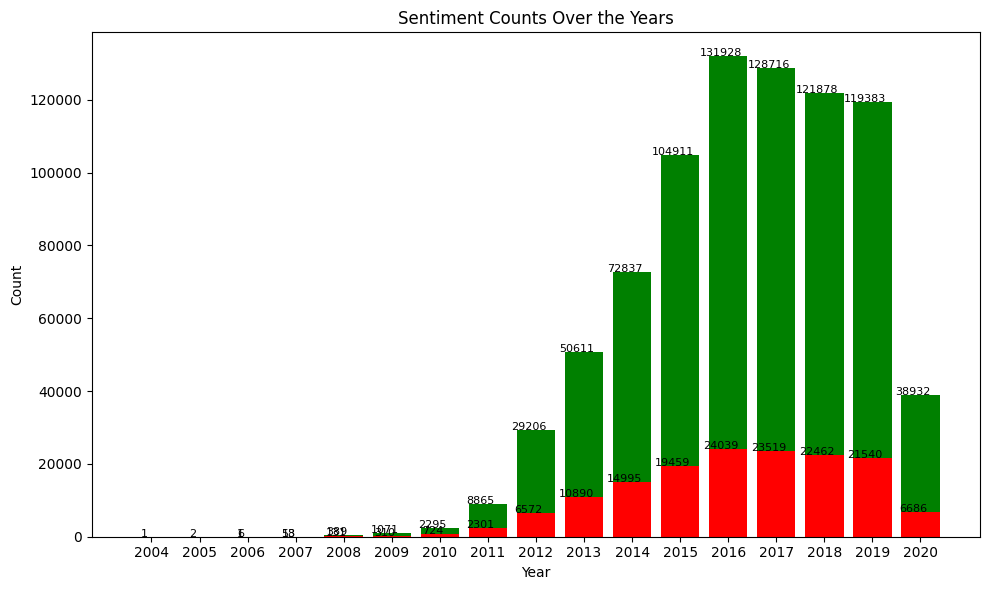

In [ ]:
plt.figure(figsize=(10, 6))
bars = plt.bar(years, counts, color=colors)

plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Sentiment Counts Over the Years')
vertical_spacing = 5
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 0.1, str(count), ha='center',fontsize=8, color='black')
plt.tight_layout()
plt.show()


In [ ]:
df = df.withColumn("month",
    when(col("month") == "January", "01")
    .when(col("month") == "February", "02")
    .when(col("month") == "March", "03")
    .when(col("month") == "April", "04")
    .when(col("month") == "May", "05")
    .when(col("month") == "June", "06")
    .when(col("month") == "July", "07")
    .when(col("month") == "August", "08")
    .when(col("month") == "September", "09")
    .when(col("month") == "October", "10")
    .when(col("month") == "November", "11")
    .when(col("month") == "December", "12")
    .otherwise(None)
)

In [ ]:
df.count()

964731

In [ ]:
df=df.dropna()
df.count()

964730

In [ ]:
df.filter(col("month").isNull()).show()

+---+-----------+---------------+-------------+------+------------+--------------+-----------+----+----+-----+
|_c0|parse_count|restaurant_name|rating_review|sample|title_review|review_preview|review_full|date|year|month|
+---+-----------+---------------+-------------+------+------------+--------------+-----------+----+----+-----+
+---+-----------+---------------+-------------+------+------------+--------------+-----------+----+----+-----+



In [ ]:
from pyspark.sql.functions import count

Trend_All_Years_Monthly = df.select("restaurant_name", "rating_review", "month", "year") \
    .filter((df["year"] >= 2016) & (df["year"] <= 2020))\
    .groupBy("year", "month") \
    .agg(count("*").alias("count")) \
    .orderBy("year", "month")

Trend_All_Years_Monthly.show(50)

+----+-----+-----+
|year|month|count|
+----+-----+-----+
|2016|   01|11204|
|2016|   02|12669|
|2016|   03|12370|
|2016|   04|12666|
|2016|   05|12650|
|2016|   06|12421|
|2016|   07|14180|
|2016|   08|14944|
|2016|   09|13533|
|2016|   10|14070|
|2016|   11|12878|
|2016|   12|12382|
|2017|   01|12994|
|2017|   02|13167|
|2017|   03|13700|
|2017|   04|13832|
|2017|   05|13772|
|2017|   06|11332|
|2017|   07|13490|
|2017|   08|12918|
|2017|   09|11863|
|2017|   10|12729|
|2017|   11|11519|
|2017|   12|10919|
|2018|   01|11569|
|2018|   02|11040|
|2018|   03|12076|
|2018|   04|12091|
|2018|   05|10948|
|2018|   06|11493|
|2018|   07|12484|
|2018|   08|13650|
|2018|   09|11596|
|2018|   10|13350|
|2018|   11|12024|
|2018|   12|12018|
|2019|   01|11811|
|2019|   02|11877|
|2019|   03|13108|
|2019|   04|11596|
|2019|   05|11939|
|2019|   06|11622|
|2019|   07|12140|
|2019|   08|12411|
|2019|   09|10992|
|2019|   10|11226|
|2019|   11|11369|
|2019|   12|10832|
|2020|   01|10112|
|2020|   02|

In [ ]:
Trend_All_Years_Monthly = Trend_All_Years_Monthly.orderBy("month")

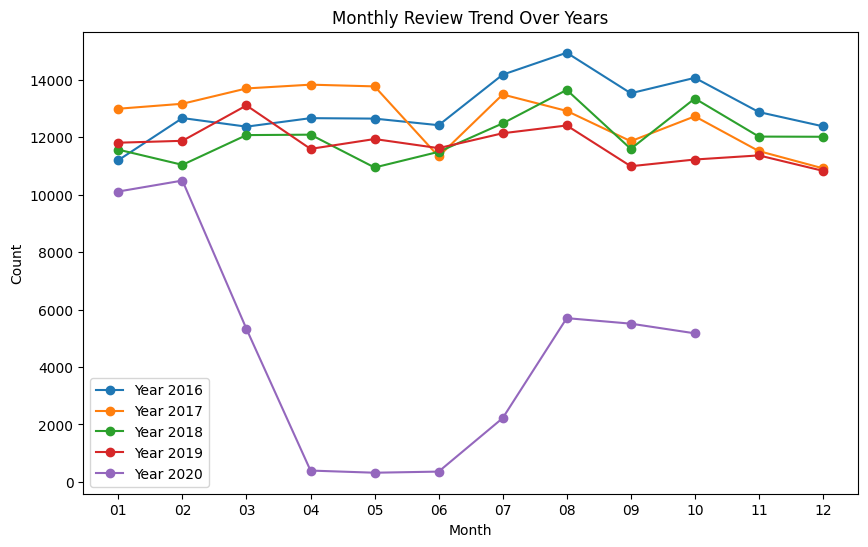

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming Trend_All_Years_Monthly is your Spark DataFrame

# Convert Spark DataFrame to Pandas
pandas_monthly = Trend_All_Years_Monthly.toPandas()

trend_pandas = pandas_monthly.dropna(subset=['month', 'count'])
# Plot the trend lines for each year
plt.figure(figsize=(10, 6))

for year, group in trend_pandas.groupby('year'):
    plt.plot(group['month'], group['count'], marker='o', linestyle='-', label=f'Year {year}')

plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Monthly Review Trend Over Years')
plt.legend()
plt.show()

In [ ]:
  Trend_2016_Monthly=df2016.select("restaurant_name","rating_review","month").groupBy("month").count()
  Trend_2016_Monthly=Trend_2016_Monthly.orderBy("month")
  data3=Trend_2016_Monthly.collect()
  month,count = zip(*data3)
  plt.figure(figsize=(10, 6))
  plt.plot(month,count, marker='o', linestyle='-')
  #plt.bar(month, count)
  plt.xlabel('month')
  plt.ylabel('Count')
  plt.title('Monthly Review Trend in 2016')
  plt.show()

NameError: ignored

In [ ]:
from pyspark.sql.functions import col

topwithtoprating = df.filter(df['rating_review']>=4.0).groupBy("restaurant_name").count().withColumnRenamed("count", "positivecount")
topwithtoprating = topwithtoprating.orderBy("count",ascending=False)
totalrating = df.groupBy("restaurant_name").count()
totalrating = totalrating.orderBy("count",ascending=False)
joined_df = topwithtoprating.join(totalrating, "restaurant_name")


In [ ]:
joined_df = joined_df.orderBy('positivecount',ascending=False)


In [ ]:
Top10_prating=joined_df.limit(10)

In [ ]:
pd_df = Top10_prating.select("restaurant_name", "count", "positivecount").toPandas()

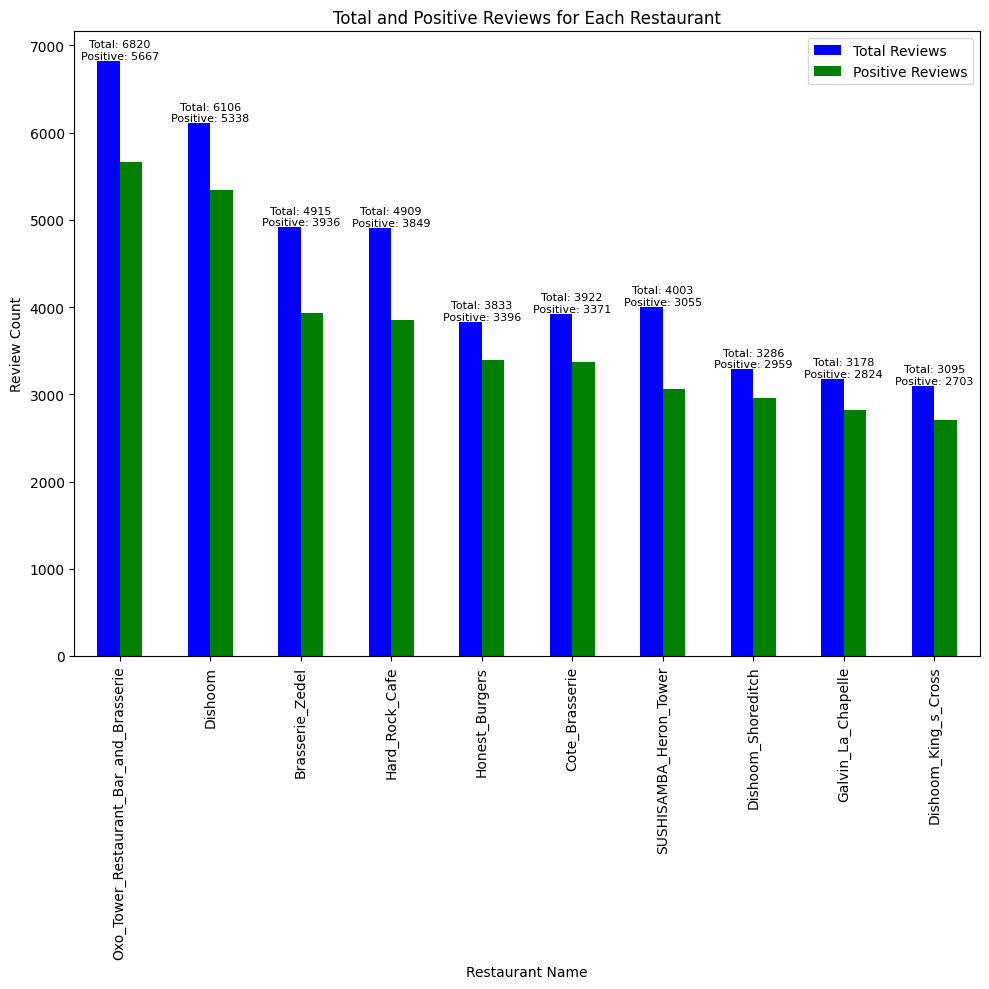

In [ ]:
pd_df.plot(kind="bar", x="restaurant_name", stacked=False, figsize=(10, 10),color=["Blue","Green"])
plt.xlabel("Restaurant Name")
plt.ylabel("Review Count")
plt.title("Total and Positive Reviews for Each Restaurant")
plt.legend(["Total Reviews", "Positive Reviews"])
vertical_spacing = 5
for index, (total, positive) in enumerate(zip(pd_df["count"], pd_df["positivecount"])):
    plt.annotate(f"Total: {total}\nPositive: {positive}", (index, total), ha='center', va='bottom', fontsize=8, color='black')
plt.tight_layout()
plt.show()

In [ ]:
topinbadrating = df.filter(df['rating_review']<3.0).groupBy("restaurant_name").count().withColumnRenamed("count", "negcount")
topinbadrating = topinbadrating.orderBy("count",ascending=False)
joined_df1 = topinbadrating.join(totalrating, "restaurant_name")
joined_df1 = joined_df1.orderBy('negcount',ascending=False)
Top10_brating=joined_df1.limit(10)
Top10_brating = Top10_brating.withColumn('poscount',(col("count")-col("negcount")))
pd_df1 = Top10_brating.select("restaurant_name", "negcount","Poscount").toPandas()

In [ ]:
pd_df1

,restaurant_name,negcount,Poscount
0,SUSHISAMBA_Heron_Tower,479,3524
1,Hard_Rock_Cafe,432,4477
2,Oxo_Tower_Restaurant_Bar_and_Brasserie,411,6409
3,Bella_Italia,404,2884
4,Brasserie_Zedel,391,4524
5,Inamo_Soho,374,1734
6,Ting_Restaurant_Lounge,365,2103
7,London_Steakhouse_Co,349,1453
8,Skylon,348,2411
9,Gaucho_Piccadilly,326,2877


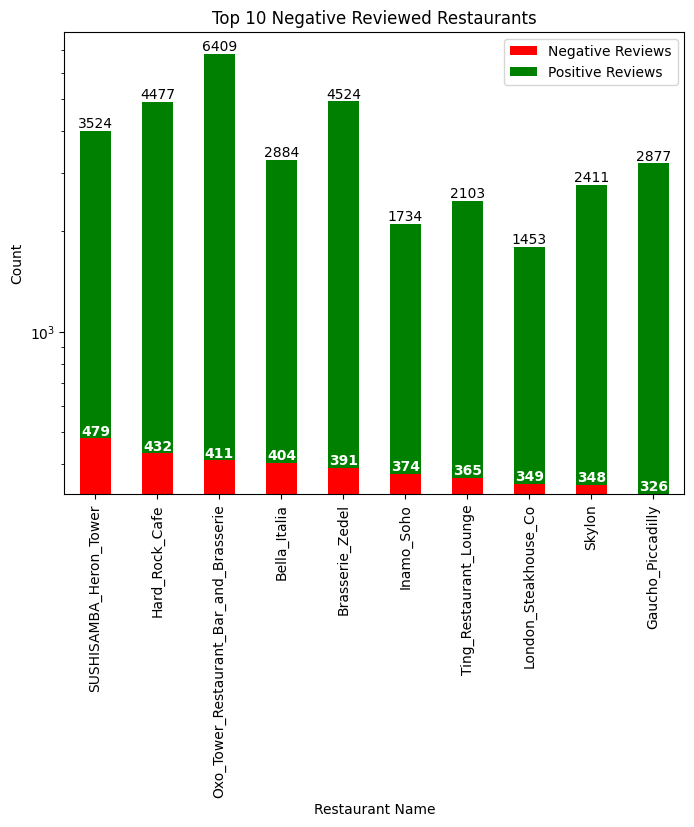

In [ ]:
pd_df1.plot(kind="bar", x="restaurant_name", stacked=True, figsize=(8, 6),color=["red","green"])
plt.xlabel("Restaurant Name")
plt.ylabel("Count")
plt.title("Top 10 Negative Reviewed Restaurants")
plt.legend(["Negative Reviews","Positive Reviews"])
plt.yscale("log")
for index, value in enumerate(pd_df1["negcount"]):
    plt.annotate(str(value), (index, value), ha='center', va='bottom', fontsize=10, color='white', weight='bold')

for index, value in enumerate(pd_df1["Poscount"]):
    plt.annotate(str(value), (index, pd_df1["negcount"][index] + value), ha='center', va='bottom', fontsize=10, color='black')

plt.show()

In [ ]:
df = df.withColumn('label', when(df['sample'] == 'Positive', 1).otherwise(0))


df = df.drop('sample')




In [ ]:

df.show(30)

+---+-----------+--------------------+-------------+--------------------+--------------------+--------------------+----+----+-----+-----+
|_c0|parse_count|     restaurant_name|rating_review|        title_review|      review_preview|         review_full|date|year|month|label|
+---+-----------+--------------------+-------------+--------------------+--------------------+--------------------+----+----+-----+-----+
|  0|          1|Cocotte_Notting_Hill|          5.0|        JUST PERFECT|I was away for co...|I was away for co...|  23|2020|   09|    1|
|  1|          2|Cocotte_Notting_Hill|          5.0|Quality food, Foo...|I recently ordere...|I recently ordere...|  23|2020|   09|    1|
|  2|          3|Cocotte_Notting_Hill|          5.0|Came here because...|Came here because...|Came here because...|  17|2020|   09|    1|
|  3|          4|Cocotte_Notting_Hill|          5.0|       Great service|My first time in ...|My first time in ...|  12|2020|   09|    1|
|  4|          5|Cocotte_Notting_H

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import HashingTF, IDF, StringIndexer, Tokenizer
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Words tokeizer
tokenizer = Tokenizer(inputCol="review_full", outputCol="words")

# Words to numerical features using HashingTF
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=10000)

# Scale features using IDF
idf = IDF(inputCol="rawFeatures", outputCol="features")

# SVM Model
svm = LinearSVC(featuresCol="features", labelCol="label", maxIter=100)

# Creating the pipeline with the stages defined above
pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, svm])

# Split the data into training and testing sets
(training_data, testing_data) = df.randomSplit([0.8, 0.2], seed=1234)

# Train the SVM model using the pipeline
model = pipeline.fit(training_data)

# Make predictions on the testing data
predictions = model.transform(testing_data)


In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Evaluating the model on the testing data
accuracy = evaluator.evaluate(predictions)

print(f"Accuracy of SVM: {accuracy * 100:.2f}%")

Accuracy: 93.70%


In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import HashingTF, IDF, StringIndexer, Tokenizer
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

tokenizer = Tokenizer(inputCol="review_full", outputCol="words")


hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=10000)


idf = IDF(inputCol="rawFeatures", outputCol="features")


#labelIndexer = StringIndexer(inputCol="sample", outputCol="indexedLabel").fit(df)


nb = NaiveBayes(featuresCol="features", labelCol="label", smoothing=1.0, modelType="multinomial")


pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, nb])


(training_data, testing_data) = df.randomSplit([0.8, 0.2], seed=1234)

model = pipeline.fit(training_data)

predictions = model.transform(testing_data)



In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print("Accuracy of NaiveBayes:", accuracy)

Accuracy of NaiveBayes: 0.9034227220449944


In [ ]:
predictions.show(10)

+------+-----------+--------------------+-------------+--------------------+--------------------+--------------------+----+----+-----+-----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|   _c0|parse_count|     restaurant_name|rating_review|        title_review|      review_preview|         review_full|date|year|month|label|               words|         rawFeatures|            features|       rawPrediction|         probability|prediction|
+------+-----------+--------------------+-------------+--------------------+--------------------+--------------------+----+----+-----+-----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|     1|          2|Cocotte_Notting_Hill|          5.0|Quality food, Foo...|I recently ordere...|I recently ordere...|  23|2020|   09|    1|[i, recently, ord...|(10000,[129,157,3...|(10000,[129,157,3...|[-2138.4185433999...|[1.52

In [ ]:
predictions_total = model.transform(df)

In [ ]:
predictions_total.count()

964730

In [ ]:
predictions_total.printSchema()

NameError: ignored

In [ ]:

from pyspark.ml.feature import StopWordsRemover
from wordcloud import WordCloud
import matplotlib.pyplot as plt



# Remove stopwords
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_tokens")
df_filtered = stopwords_remover.transform(predictions_total)

# Separate positive and negative data
positive_data = df_filtered.filter(df_filtered.rating_review == "5.0")
negative_data = df_filtered.filter(df_filtered.rating_review=="" 0)

# Combine tokens into strings
positive_text = " ".join(positive_data.select("filtered_tokens").rdd.flatMap(lambda x: x[0]).collect())
negative_text = " ".join(negative_data.select("filtered_tokens").rdd.flatMap(lambda x: x[0]).collect())

# Generate word clouds
wordcloud_positive = WordCloud(width=800, height=400, background_color="white").generate(positive_text)
wordcloud_negative = WordCloud(width=800, height=400, background_color="white").generate(negative_text)

# Display the word clouds
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation="bilinear")
plt.title("Positive Word Cloud")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation="bilinear")
plt.title("Negative Word Cloud")
plt.axis("off")

plt.show()

In [ ]:
single_review_df = spark.createDataFrame([("restaurant is ok",)], ["review_full"])


predictions_new_data = model.transform(single_review_df)

predictions_new_data.select("review_full", "prediction").show()

+----------------+----------+
|     review_full|prediction|
+----------------+----------+
|restaurant is ok|       1.0|
+----------------+----------+



In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import HashingTF, IDF, StringIndexer, Tokenizer
from pyspark.ml.classification import LogisticRegression



tokenizer = Tokenizer(inputCol="review_full", outputCol="words")


hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=10000)


idf = IDF(inputCol="rawFeatures", outputCol="features")


#labelIndexer = StringIndexer(inputCol="sample", outputCol="indexedLabel").fit(df)


lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=10, regParam=0.3, elasticNetParam=0.8)


lr_pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, lr])



(training_data, testing_data) = df.randomSplit([0.8, 0.2], seed=1234)


lr_model = lr_pipeline.fit(training_data)

lr_predictions = lr_model.transform(testing_data)




In [ ]:
lr_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
lr_accuracy = lr_evaluator.evaluate(lr_predictions)

print("Logistic Regression Accuracy:", lr_accuracy)

Logistic Regression Accuracy: 0.8420146026426307


In [ ]:
lr_predictions.show(10)

+------+-----------+--------------------+-------------+--------------------+--------------------+--------------------+----+----+-----+-----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|   _c0|parse_count|     restaurant_name|rating_review|        title_review|      review_preview|         review_full|date|year|month|label|               words|         rawFeatures|            features|       rawPrediction|         probability|prediction|
+------+-----------+--------------------+-------------+--------------------+--------------------+--------------------+----+----+-----+-----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|     1|          2|Cocotte_Notting_Hill|          5.0|Quality food, Foo...|I recently ordere...|I recently ordere...|  23|2020|   09|    1|[i, recently, ord...|(10000,[129,157,3...|(10000,[129,157,3...|[-1.6613390243990...|[0.15

In [ ]:
lr_predictions.select("probability").first()[0]

DenseVector([0.1596, 0.8404])

In [ ]:
from pyspark.sql.functions import desc


best_reviews = lr_predictions.orderBy(desc('probability')).limit(10)

best_reviews.select("restaurant_name","rating_review","review_full", "probability").show(truncate=False)

+----------------------------+-------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import HashingTF, IDF, StringIndexer, Tokenizer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator




tokenizer = Tokenizer(inputCol="review_full", outputCol="words")


hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=10000)

idf = IDF(inputCol="rawFeatures", outputCol="features")


#labelIndexer = StringIndexer(inputCol="sample", outputCol="label").fit(df)


rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=10)


rfpipeline = Pipeline(stages=[tokenizer, hashingTF, idf, rf])


(training_data, testing_data) = df.randomSplit([0.8, 0.2], seed=1234)


rfmodel = rfpipeline.fit(training_data)


predictions = rfmodel.transform(testing_data)


rfevaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
rfarea_under_roc = rfevaluator.evaluate(predictions)

In [ ]:
print("Random Forests Area under ROC:", rfarea_under_roc)

Random Forests Area under ROC: 0.7935042611206228


In [ ]:
accuracy = evaluator.evaluate(predictions)

In [ ]:
print("accuracy for Random forest:",accuracy)

accuracy for Random forest: 0.903303028252939


In [ ]:
predictions = model.transform(df)

In [ ]:
predictions.count()

964731

In [ ]:
best_review = predictions.orderBy('probability',ascending=False).limit(10)

In [ ]:

# Display the best review
best_review.select("restaurant_name","review_full", "probability").show(truncate=False)

**Vader Lexicons**

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
df.show()

+---+-----------+--------------------+-------------+--------+--------------------+--------------------+--------------------+----+----+-----+
|_c0|parse_count|     restaurant_name|rating_review|  sample|        title_review|      review_preview|         review_full|date|year|month|
+---+-----------+--------------------+-------------+--------+--------------------+--------------------+--------------------+----+----+-----+
|  0|          1|Cocotte_Notting_Hill|          5.0|Positive|        JUST PERFECT|I was away for co...|I was away for co...|  23|2020|   09|
|  1|          2|Cocotte_Notting_Hill|          5.0|Positive|Quality food, Foo...|I recently ordere...|I recently ordere...|  23|2020|   09|
|  2|          3|Cocotte_Notting_Hill|          5.0|Positive|Came here because...|Came here because...|Came here because...|  17|2020|   09|
|  3|          4|Cocotte_Notting_Hill|          5.0|Positive|       Great service|My first time in ...|My first time in ...|  12|2020|   09|
|  4|        

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType, StructField, FloatType
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    scores = sia.polarity_scores(text)
    return scores['pos'], scores['neg'], scores['compound'], scores['neu']

# Register the UDF with appropriate return type
sentiment_udf = udf(analyze_sentiment, returnType=StructType([
    StructField("Positive", FloatType(), True),
    StructField("Negative", FloatType(), True),
    StructField("Compound", FloatType(), True),
    StructField("Neutral", FloatType(), True)
]))

# Apply the UDF to the DataFrame
df = df.withColumn("SentimentScores", sentiment_udf("review_full"))


In [ ]:
df.show(10)

+---+-----------+--------------------+-------------+--------+--------------------+--------------------+--------------------+----+----+-----+--------------------+
|_c0|parse_count|     restaurant_name|rating_review|  sample|        title_review|      review_preview|         review_full|date|year|month|     SentimentScores|
+---+-----------+--------------------+-------------+--------+--------------------+--------------------+--------------------+----+----+-----+--------------------+
|  0|          1|Cocotte_Notting_Hill|          5.0|Positive|        JUST PERFECT|I was away for co...|I was away for co...|  23|2020|   09|{0.391, 0.0, 0.97...|
|  1|          2|Cocotte_Notting_Hill|          5.0|Positive|Quality food, Foo...|I recently ordere...|I recently ordere...|  23|2020|   09|{0.291, 0.0, 0.98...|
|  2|          3|Cocotte_Notting_Hill|          5.0|Positive|Came here because...|Came here because...|Came here because...|  17|2020|   09|{0.115, 0.049, 0....|
|  3|          4|Cocotte_Not

In [ ]:
# Extract values from the struct into separate columns
df = df.selectExpr("_c0", "restaurant_name","rating_review","sample", "SentimentScores.Positive", "SentimentScores.Negative", "SentimentScores.Compound", "SentimentScores.Neutral")

# Show the result
df.show(truncate=False)

+---+----------------------------------------+-------------+--------+--------+--------+--------+-------+
|_c0|restaurant_name                         |rating_review|sample  |Positive|Negative|Compound|Neutral|
+---+----------------------------------------+-------------+--------+--------+--------+--------+-------+
|0  |Cocotte_Notting_Hill                    |5.0          |Positive|0.391   |0.0     |0.9791  |0.609  |
|1  |Cocotte_Notting_Hill                    |5.0          |Positive|0.291   |0.0     |0.9867  |0.709  |
|2  |Cocotte_Notting_Hill                    |5.0          |Positive|0.115   |0.049   |0.7469  |0.837  |
|3  |Cocotte_Notting_Hill                    |5.0          |Positive|0.228   |0.0     |0.9081  |0.772  |
|4  |Cocotte_Notting_Hill                    |5.0          |Positive|0.306   |0.02    |0.9921  |0.674  |
|5  |Cocotte_Notting_Hill                    |5.0          |Positive|0.481   |0.0     |0.9186  |0.519  |
|6  |Cocotte_Notting_Hill                    |5.0      

In [ ]:
df.count()

964731

In [ ]:
import nltk
nltk.download('vader_lexicon')

from pyspark.sql.functions import udf
from pyspark.sql.types import StructType, StructField, FloatType
from nltk.sentiment import SentimentIntensityAnalyzer



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


{'neg': 0.0, 'neu': 0.749, 'pos': 0.251, 'compound': 0.3291}

In [ ]:
pandasdf = df.toPandas()

In [ ]:
pandasdf = pd.read_csv("/content/drive/MyDrive/sentimentscores.csv")

In [ ]:
len(pandasdf)

964731

In [ ]:
import pandas as pd

pandasdf['_c0'] = pd.to_numeric(pandasdf['_c0'], errors ='coerce')
pandasdf['Compound'] = pd.to_numeric(pandasdf['Compound'], errors='coerce')
pandasdf['Positive'] = pd.to_numeric(pandasdf['Positive'], errors='coerce')
pandasdf['Negative'] = pd.to_numeric(pandasdf['Negative'], errors='coerce')
pandasdf['Neutral'] = pd.to_numeric(pandasdf['Neutral'], errors='coerce')

In [ ]:
pandasdf.head(10)

,_c0,restaurant_name,rating_review,sample,Positive,Negative,Compound,Neutral
0,0,Cocotte_Notting_Hill,5.0,Positive,0.391,0.000,0.9791,0.609
1,1,Cocotte_Notting_Hill,5.0,Positive,0.291,0.000,0.9867,0.709
2,2,Cocotte_Notting_Hill,5.0,Positive,0.115,0.049,0.7469,0.837
3,3,Cocotte_Notting_Hill,5.0,Positive,0.228,0.000,0.9081,0.772
4,4,Cocotte_Notting_Hill,5.0,Positive,0.306,0.020,0.9921,0.674
5,5,Cocotte_Notting_Hill,5.0,Positive,0.481,0.000,0.9186,0.519
6,6,Cocotte_Notting_Hill,5.0,Positive,0.414,0.000,0.9901,0.586
7,7,Cocotte_Notting_Hill,5.0,Positive,0.216,0.000,0.9523,0.784
8,8,Cocotte_Notting_Hill,5.0,Positive,0.282,0.012,0.9846,0.706
9,9,Cocotte_Notting_Hill,5.0,Positive,0.486,0.000,0.9580,0.514


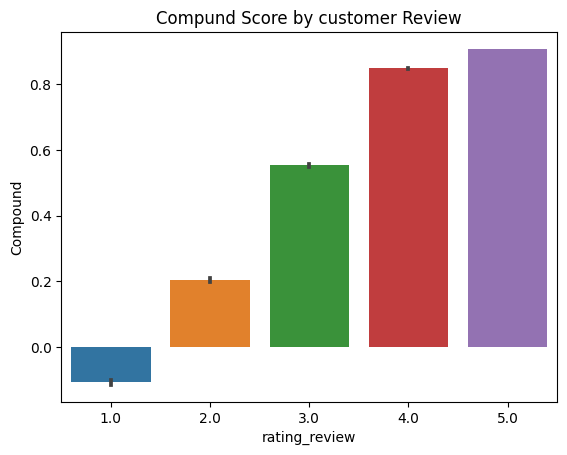

In [ ]:
import seaborn as sns

rating_order = ['5.0', '4.0', '3.0', '2.0', '1.0']
ax = sns.barplot(data=pandasdf, x='rating_review', y='Compound')
ax.set_title('Compund Score by customer Review')
plt.show()

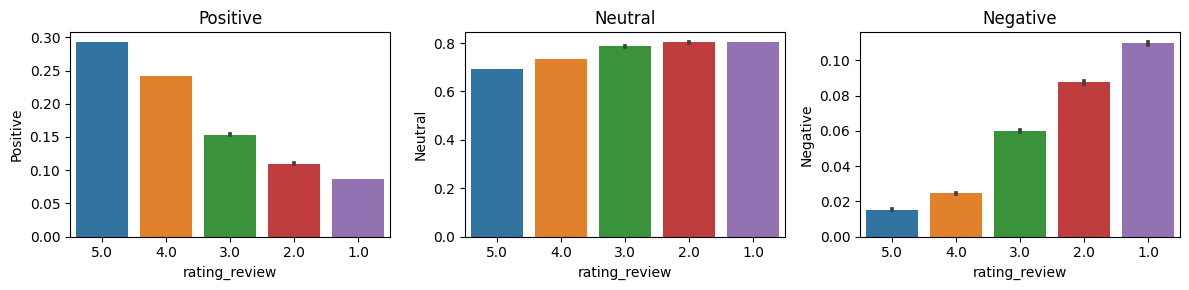

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=pandasdf, x='rating_review', y='Positive',order=rating_order, ax=axs[0])
sns.barplot(data=pandasdf, x='rating_review', y='Neutral',order=rating_order, ax=axs[1])
sns.barplot(data=pandasdf, x='rating_review', y='Negative',order=rating_order, ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

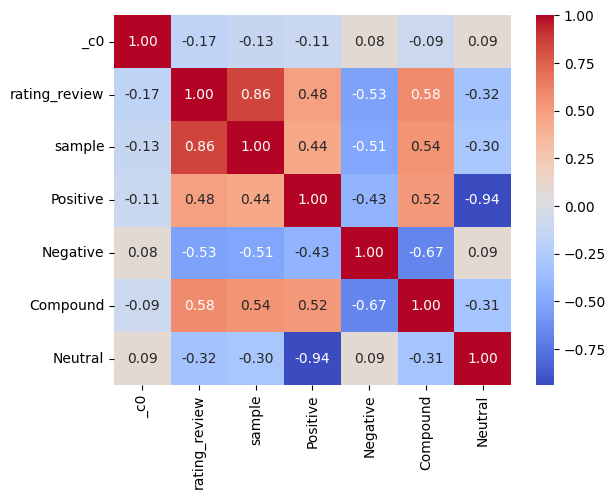

In [ ]:
pandasdf['sample']=pandasdf['sample'].map({'Positive': 1, 'Negative': 0})
numeric_features = pandasdf.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
correlation_matrix = numeric_features.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Ensure 'Compound' is numeric


# Features and target
X = pandasdf[['Compound']]
y = pandasdf['sample']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train a machine learning model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
predictions = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)

#logistic regression accuracy
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)


Accuracy: 0.88
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.35      0.49     30796
           1       0.89      0.98      0.93    162151

    accuracy                           0.88    192947
   macro avg       0.84      0.67      0.71    192947
weighted avg       0.87      0.88      0.86    192947



In [ ]:
numeric_features = df.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
correlation_matrix = numeric_features.corr()

# Display the correlation matrix
print(correlation_matrix)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import mean_squared_error, r2_score

# Assuming 'Compound' is already numeric and 'sample1' is the target variable

# Features and target
X = pandasdf[['Positive', 'Negative', 'Neutral']]
y = pandasdf['rating_review']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train a Naive Bayes classifier (or use a regression model if 'rating_review' is numeric)
model = MultinomialNB()
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Evaluate the model for regression
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

Mean Squared Error: 1.50
R-squared: -0.44


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB  # Change to BernoulliNB
from sklearn.metrics import accuracy_score, classification_report

# Assuming 'Compound' is already numeric and 'sample1' is the target variable

# Features and target
X = pandasdf[['Compound']]
y = pandasdf['sample']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a CountVectorizer to convert numeric data into bag-of-words representation
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train['Compound'].astype(str))
X_test_vectorized = vectorizer.transform(X_test['Compound'].astype(str))

# Create and train a Naive Bayes classifier
model = BernoulliNB()
model.fit(X_train_vectorized, y_train)

# Make predictions on the test set
predictions = model.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)

#Accuracy for Naive Bayes
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)

Accuracy: 0.85
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.24      0.34     30796
           1       0.87      0.97      0.92    162151

    accuracy                           0.85    192947
   macro avg       0.74      0.60      0.63    192947
weighted avg       0.83      0.85      0.83    192947



In [ ]:

from sklearn.ensemble import RandomForestClassifier


# Ensure 'Compound' is numeric


# Features and target
X = pandasdf[['Positive','Negative','Neutral']]
y = pandasdf['sample']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train a Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
predictions = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)

Accuracy: 0.88
Classification Report:
               precision    recall  f1-score   support

    Negative       0.68      0.52      0.59     30796
    Positive       0.91      0.95      0.93    162151

    accuracy                           0.88    192947
   macro avg       0.80      0.73      0.76    192947
weighted avg       0.87      0.88      0.88    192947



In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
sia = SentimentIntensityAnalyzer()
score=sia.polarity_scores(" :( ")
print(score)
single_compound_value = [[score['pos'],score['neg'],score['neu']]]
feature_names = ['pos','neg', 'neu']
# prediction
prediction = rf_classifier.predict(single_compound_value)
print("Predicted Class:", prediction)

{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.4404}
Predicted Class: ['Negative']


In [ ]:
from sklearn.ensemble import RandomForestClassifier



# Features and target
X = pandasdf[['Positive','Negative','Neutral']]
y = pandasdf['rating_review']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train a Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
predictions = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)

Accuracy: 0.59
Classification Report:
               precision    recall  f1-score   support

         1.0       0.32      0.29      0.31      6607
         2.0       0.22      0.17      0.19      7687
         3.0       0.26      0.17      0.20     16502
         4.0       0.29      0.11      0.16     47999
         5.0       0.68      0.90      0.77    114152

    accuracy                           0.59    192947
   macro avg       0.35      0.33      0.33    192947
weighted avg       0.51      0.59      0.53    192947



df.show(10)